# Principal component analysis and k-means clustering of restaurant data

The main goal of this notebook it to analyze and make sense of the restaurant makeup of the LA neighborhoods. Specifically, I am interested in separating the neighborhoods into culinary clusters that share a similar restaurant makeup. To these ends, I'll be using 2 unsupervised machine learning algorithms: principal component analysis and k-means clustering. At the end of the notebook, I will find that there are roughly 5 different culinary clusters. Most interestingly, I will show that these 5 clusters form natural geographic clusters, even though no geographic data was given to the model.

In [1]:
#First grab the modules we'll need in this analysis...
import seaborn as sns; sns.set()
import pandas as pd
import requests
import folium
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
#%matplotlib inline

First I'll read in the processed data:

In [2]:
input_df = pd.read_csv('processed/restaurant_model_input.csv').set_index("Neighborhood")
input_df.shape

(151, 112)

Next I'll examine the data using principal component analysis (PCA). PCA allows us to look at the variance and intrinsic dimensionality of the restaurant data. It will also come in handy for visualizing the clustering later on. Intuitively, PCA fits a p-dimensional elipsoid to the data set, where p = number of features (112 in this example). The symmetry axes of the elipsoid are the principal component eigenvectors along a specific direction and the variance is given by their associated eigenvalues. The larger the eigenvalue, the more important a principal component is in explaining the data variance.

In this example, I am starting with 112 restaurant types, but through PCA I will be able to identify a smaller set of linear combinations of these types that explain most of the variance in the data. Mathematically, PCA will go through the following steps:

 1. Calculate the covariance matrix A$^{T}$A/(n-1), where A is the 151 x 112 centered restaurant input and n=151.
 
 2. Calculate eigenvalues and eigenvectors of the 112 x 112 covariance matrix and sort by the magnitude of the eigenvalues. PC1 corresponds to the eigenvector with the largest eigenvalue, and so on. 

Before running PCA it is critical to center each column at the mean, and to possibly rescale such that the scale between columns are comparable (e.g. setting them to unit variance). 

For this dataset, each column represents the proportion of a particular restaurant type. I will go ahead and center at 0 mean. I will not rescale the columns, however, since they are already on the same scale.

In [3]:
# First center at 0 mean
input_c = scale(input_df, with_mean=True, with_std=False)

Now run PCA and return top 60 components.

In [4]:
pca = PCA(n_components=60)

In [5]:
pca.fit(input_c)

PCA(copy=True, iterated_power='auto', n_components=60, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Now let's plot the variance explained by each component, both as a cumulative sum and for the values themselves:

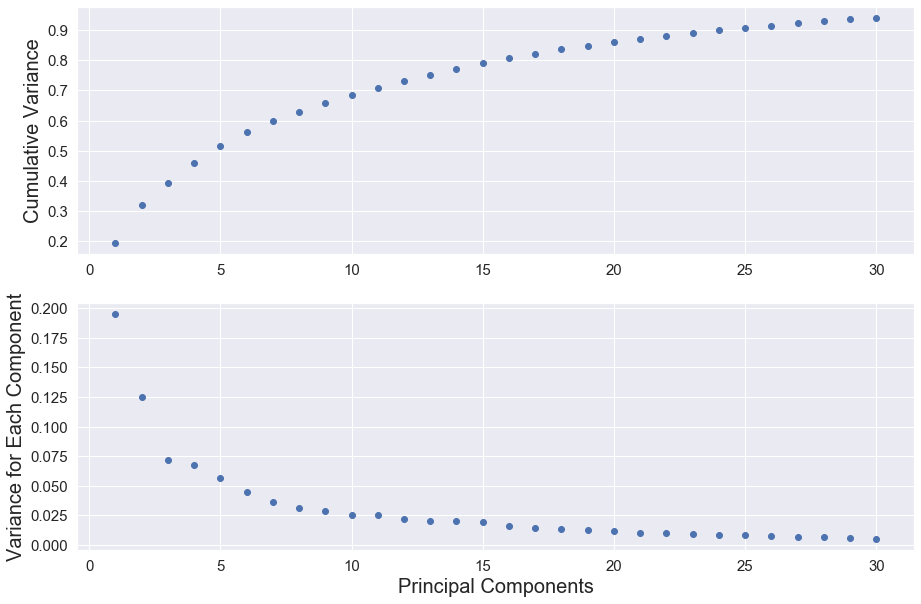

In [6]:
fig = plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(list(range(1,31,1)), np.cumsum(pca.explained_variance_ratio_)[0:30], 'o')
plt.ylabel("Cumulative Variance", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(212)
plt.plot(list(range(1,31,1)),pca.explained_variance_ratio_[0:30], 'o')
plt.xlabel("Principal Components", fontsize=20)
plt.ylabel("Variance for Each Component", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.savefig('pca_variance.png',dpi=600,bbox_inches="tight") 
plt.show()


Here, we can see that a majority of the variance is explained by the first 5 components and ~95% is explained with 30 components. The intrinsic dimensionality of the data seems to be somewhere in this range of 5 - 30 depending on how much of the variance one would like to consider.

Now that we have a rough idea about the data dimensionality and variance, let's try separating the LA times neighborhoods into culinary clusters. In this case I'll use the k-means algorithm, one of the simplest clustering algorithms. This algorithm has the following steps:

 1. Choose a value for k. Initialize k cluster centroids at random data points (neighborhoods) in the data set. The algorithm can get stuck in local minima, so it is generally advised to run it several times with random initialization.
   
 2. Assign every data point to the nearest centroid, forming k separate clusters. Note: unlike some clustering algorithms, such as DBSCAN, all of the data points are assigned to a cluster.
   
 3.  Find the mean value of the coordinates for the members of each cluster.
    
 4. Shift the centroid to the mean value, and go back to step 3. Repeat until there is no change in the cluster assignments.

The main input for k means is k, or the number of clusters. Choosing k is not always straightforward and in some applications there may be a specified k (e.g. t shirt sizes). I would like to see if there is a natural choice of k that is present in the data, corresponding to a natural number of culinary clusters. Here I'll examine two metrics for evaluating k:

 - [Inertia](https://scikit-learn.org/stable/modules/clustering.html): the within cluster sum of squares distance to the centroid. So, a lower inertia is 'better' as it corresponds to more compact and spherical clusters (although spherical is not always prefered...). The inertia will always decrease with larger k. The 'elbow method' can be used to evaluate the inertia as a function of k, by choosing a k that corresponds to the 'elbow' in the curve.
 
 - [Silhouette Score](https://scikit-learn.org/stable/modules/clustering.html): takes into account (a) the mean distance between a data point and all other points in its  cluster and (b) the mean distance between a data point and all other points in the nearest cluster. The coefficient is defined as the mean of (b-a)/max(a,b) over all points. A larger score is better, as it corresponds to more compact clusters, that are distinct from each other.
 
 
 
  I'll randomly initialize the algorithm 50 times for each run, so it is not stuck in a local minima. The [k-means++ keyword](https://scikit-learn.org/stable/modules/clustering.html) specifies semi-random initial centroids that are more distant from each other, which has been shown to perform better than a purely random initialization.

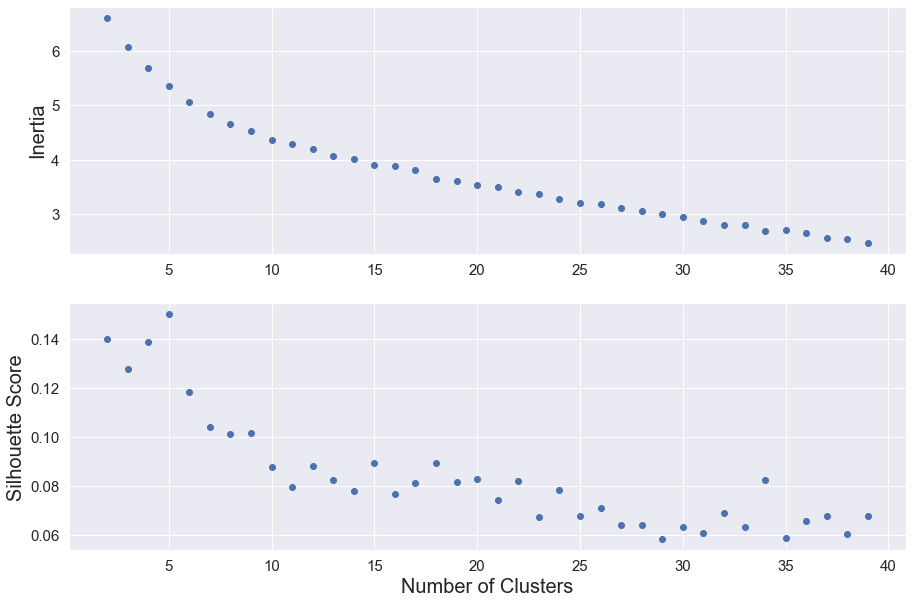

In [7]:
sc = {}
sse = {}
for k in range(2, 40):
    kmeans = KMeans(n_clusters=k, random_state=1, init='k-means++' , n_init=50).fit(input_c)
    label = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    sil_coeff = silhouette_score(input_c, label, metric='euclidean')
    sc[k] = sil_coeff
fig = plt.figure(figsize=(15,10))
plt.subplot(211)
ax = plt.plot(list(sse.keys()), list(sse.values()), 'o')
#plt.xlabel("Number of Clusters",fontsize=15)
plt.tick_params(labelsize=15)
plt.ylabel("Inertia",fontsize=20)
plt.subplot(212)
plt.plot(list(sc.keys()), list(sc.values()), 'o')
plt.xlabel("Number of Clusters", fontsize=20)
plt.tick_params(labelsize=15)
plt.ylabel("Silhouette Score",fontsize=20)
plt.tick_params(labelsize=15)
fig.savefig('inertia_ss_plot.png',dpi=600,bbox_inches="tight") 
plt.show()


The inertia shows a very gradual elbow near k = 3-8, while the silhouette score peaks at k=5. I will proceed with k=5 as this seems to be a natural choice for k in the data.

Visualizing the clusters is not straightforward, since the feature space has 112 dimensions. One common way to visualize the clustering results of high dimensional feature space is to plot on the first few principal components. This allows us to take slices of the data in the directions that contain most of the variance. 

Let's run k-means for k=5 and plot the clusters on the first five principal components (PC1, PC2,...)

In [8]:
# run k-means with 50 random initializations and k=5
kmeans = KMeans(n_clusters=5, random_state=1, init='k-means++' ,n_init=50).fit(input_c)
# run PCA and get first 5 PCs
pca = PCA()
reduced_data = pca.fit_transform(input_c)

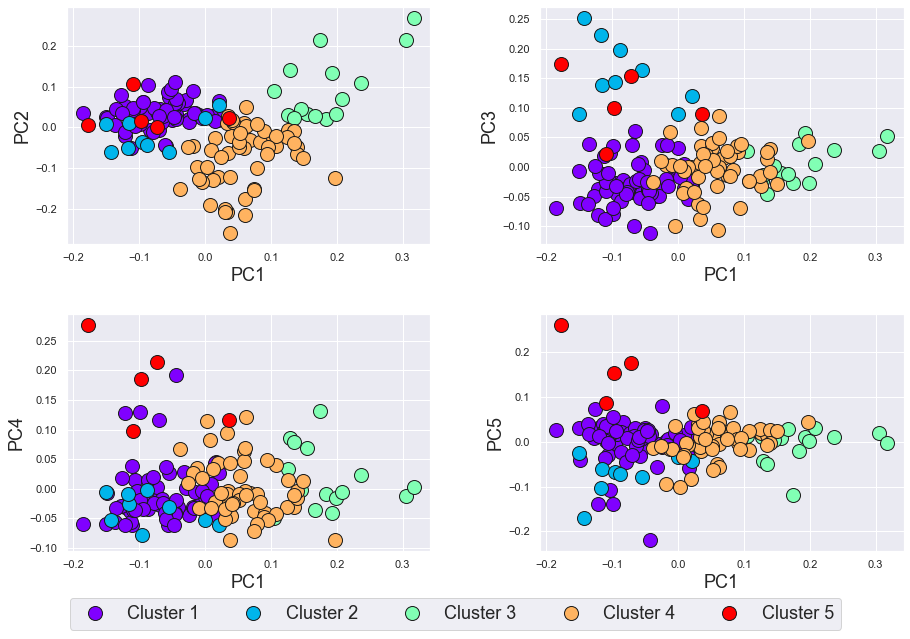

In [9]:
# plot projections of the clustering results on the PCs
fig = plt.figure(figsize=(15,10))
#fig.suptitle("Projections of the clusters on the principal components" , fontsize=25, y=0.95)
for pc_n in range(2,6,1):
    curr_plot = "22" + str(pc_n-1)
    plt.subplot(int(curr_plot))
    labels = kmeans.labels_
    X = reduced_data

    unique_labels = set(labels)
    colors_list = [plt.cm.rainbow(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors_list):
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        line, = plt.plot(xy[:, 0], xy[:, pc_n-1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)
        if pc_n==2:
            line.set_label("Cluster " + str(k+1))
        plt.xlabel("PC1", fontsize=18)
        plt.ylabel("PC" + str(pc_n),  fontsize=18)
#fig.axes[0].legend(loc="center right")
fig.legend(loc="lower center", ncol=5,  fontsize=18)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
fig.savefig('pca_clusters.png',dpi=600,bbox_inches="tight") 
plt.show()


The goal of these plots are to show that the clusters are all distinct and separate in at least 1 dimension. In other words, they form separate clusters in the restaurant type space.

In the PC2 - PC1 projection, we can see that clusters 1, 3, and 4 are cleanly separated into distinct groups. Clusters 1, 2, and 5 are not as cleanly separated in this plot. However, clusters 1, 2, and 5 are cleanly separated upon examination of the PC3 - PC1, PC4 - PC1, and PC5 - PC1 projections. For example, PC5 - PC1 shows a large separation between clusters 5 and 2. Overall, these plots show that all of the clusters are cleanly separated after projection in the first few principal components.

What are the restaurant types with the largest proportions in the eigenvectors of each principal component? In other words, this gives us the restaurant types that are associated with the axes in the cluster plots.

In [10]:
pca_components = pd.DataFrame(pca.components_)
pca_components.columns = input_df.columns
pca_components = pca_components.transpose()
PCs_rest = pca_components.copy()
for x in range(len(pca_components.columns)):
    PCs_rest[x] = pca_components.reindex(
        pca_components.abs().sort_values(
            by=x, ascending=False).index).index#sort by absolute value
PCs_rest = PCs_rest.reset_index()
PCs_rest.drop('index', axis = 1, inplace=True)
PCs_rest.columns=["PC" + str(i) for i in range(1,113,1)]
PCs_rest.index = range(1, 113, 1)
PCs_rest.transpose()[[1,2,3,4,5]].head(5)

,1,2,3,4,5
PC1,Mexican Restaurant,Fast Food Restaurant,Burger Joint,Italian Restaurant,Café
PC2,Mexican Restaurant,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place,Food
PC3,Chinese Restaurant,Korean Restaurant,American Restaurant,Food Truck,Vietnamese Restaurant
PC4,Korean Restaurant,Food Truck,Burger Joint,Sandwich Place,Italian Restaurant
PC5,Food Truck,Korean Restaurant,Chinese Restaurant,Burger Joint,Italian Restaurant


So, PC1 and PC2 have the largest components in the Mexican food direction. PC3 is most associated with Chinese food, PC4 with Korean food, and PC5 with food trucks.

Now that I have identified the PCs and 5 natural clusters, the next question is: what is the make-up of these clusters? I'll make a barplot to visualize their components:

In [11]:
# First let's get a df ready with the neighborhood coordinates and cluster labels. This will be used
# for the next section
centroids = gpd.read_file('processed/la_times_centroids.shp')
cluster_results = input_df.copy().reset_index()
cluster_results.insert(0, 'Cluster Labels', kmeans.labels_+1)
# la_merged contains k-means results and coords
la_merged = centroids.merge(cluster_results[['Cluster Labels', 'Neighborhood']],
                            how='inner', left_on = 'name', right_on='Neighborhood')
la_merged.drop(['name','r_list'], axis=1, inplace=True)
cluster_results.drop('Neighborhood', axis=1, inplace=True)
# cluster_results contains k-means results and restaurant types
cluster_results.set_index("Cluster Labels", inplace=True)

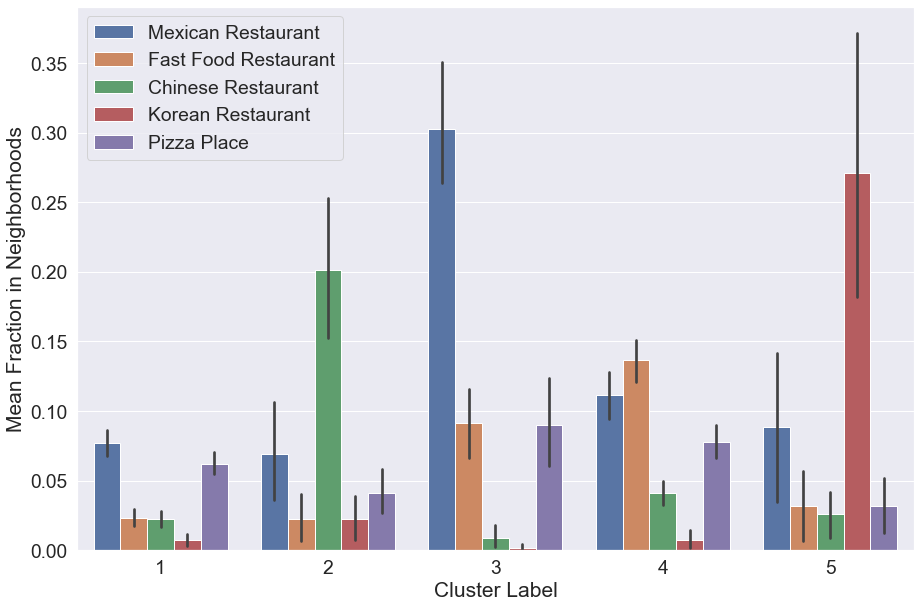

In [12]:
# First we'll plot the distribution of restaurants in each cluster
cluster_grouped = cluster_results.groupby('Cluster Labels').mean()
cutoff = 3 #choose number of top venues to display in barchart
c_0 = cluster_grouped.loc[[1]].sort_values(by=[1],axis=1,ascending=True).iloc[:,-2:]
c_1 = cluster_grouped.loc[[2]].sort_values(by=[2],axis=1,ascending=True).iloc[:,-2:]
c_2 = cluster_grouped.loc[[3]].sort_values(by=[3],axis=1,ascending=True).iloc[:,-2:]
c_3 = cluster_grouped.loc[[4]].sort_values(by=[4],axis=1,ascending=True).iloc[:,-2:]
c_4 = cluster_grouped.loc[[5]].sort_values(by=[5],axis=1,ascending=True).iloc[:,-2:]
set0 = set(c_0.columns)
total_set = set0.union(c_0.columns,c_1.columns,c_2.columns,c_3.columns,c_4.columns)
cluster_results_top = cluster_results.transpose().loc[total_set].transpose()
plot_data = pd.melt(cluster_results_top.reset_index(), id_vars=["Cluster Labels"], value_vars=cluster_results_top.columns)
plt.figure(figsize=(15,10))
sns.set(font_scale = 1.75)
ax = sns.barplot(y="value", x="Cluster Labels", hue='variable', data=plot_data,orient='v')
ax.legend().set_title('')
ax.set_ylabel('Mean Fraction in Neighborhoods')
ax.set_xlabel("Cluster Label")
fig = ax.get_figure()
fig.savefig('cluster_barplot.png',dpi=600,bbox_inches="tight") 

The barplot reveals some key distictions between the neighborhood clusters. For example, cluster 2 is associated with Chinese food, 3 with Mexican food, and 5 with Korean food. 1 and 4 are similar, but 4 has considerably more fast food, while 1 is more mixed.

Let's examine the geographic distribution of these clusters with folium:

In [13]:
# Now Let's create the folium map
la_coords = [34.0522, -118.2437]#coordinates for LA 
map_clusters = folium.Map(location=la_coords, zoom_start=10,tiles='cartodbpositron')


color_list = [plt.cm.rainbow(each)
          for each in np.linspace(0.0, 1.0, len(unique_labels))]
rainbow = [colors.rgb2hex(i) for i in color_list]
# add markers to the map
markers_colors = []
for latlon, poi, cluster in zip(la_merged['geometry'], la_merged['Neighborhood'], la_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [latlon.y,latlon.x],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)   
legend_html = '''
    <div  style="font-family:verdana">
    <h4> Culinary Clusters of LA </h4>
    1: Mix/Mexican/Pizza
    <svg height="20" width="40">
   <circle cx="10" cy="12" r="6" stroke="{}" stroke-width="2" fill="{}" />
 </svg>  
    2: Chinese Food
    <svg height="20" width="40">
   <circle cx="10" cy="12" r="6" stroke="{}" stroke-width="2" fill="{}" />
 </svg> 
    3: Mexican Food
    <svg height="20" width="40">
   <circle cx="10" cy="12" r="6" stroke="{}" stroke-width="2" fill="{}" />
 </svg>
     4: Fast Food
    <svg height="20" width="40">
   <circle cx="10" cy="12" r="6" stroke="{}" stroke-width="2" fill="{}" />
 </svg> 
     5: Korean food
    <svg height="20" width="40">
   <circle cx="10" cy="12" r="6" stroke="{}" stroke-width="2" fill="{}" />
 </svg> 
    </div>

     '''.format(rainbow[0],rainbow[0],rainbow[1],rainbow[1],rainbow[2],rainbow[2],
               rainbow[3],rainbow[3],rainbow[4],rainbow[4])
map_clusters.get_root().html.add_child(folium.Element(legend_html))
map_clusters

Although no geographical information was included in the clustering, we see the emergence of culinary regions of LA. Cluster 1 (most mixed with Mexican food/pizza) extends from the Manhattan Beach - Santa Monica shoreline north into Burbank. Cluster 2 is associated with Chinese food, and it extends from Chinatown East towards Alhambra and San Gabriel. As an aside, I lived for several years in Alhambra, and I can confirm that there is a great variety of Chinese restaurants in that area. The Mexican food cluster (3) is more dispersed from Boyle Heights our towards Whittier. Finally, the Korean food cluster (5) is mostly localized in the neighborhoods near Koreatown.